Разделяем слой с остановками на уникальные маршруты, поскольку есть маршруты в разных областях ЛО c одинаковыми названиями, необходимо применить кластеризацию по расположению с искуственным шумом. Если все маршруты уникальные это не требуется

In [3]:
from shapely import Point
import pandas as pd
from tqdm.auto import tqdm
import geopandas as gpd
from src.dongraphio.utils.geometry_utils import clusterize_kmeans_geo_points

tqdm.pandas()

stops_gdf = gpd.read_file("stopsLO.geojson")
stops_gdf.rename(columns={"Автоб": "route"}, inplace=True)
stops_gdf.dropna(subset="route", axis=0, inplace=True, how="any")
unique_routes = set()
for index, row in (stops_gdf.iterrows()):
    for i in str(row["route"]).replace('.', ',').rstrip().lstrip().split(","):
        if i != "":
            unique_routes.add(i.lstrip().rstrip())
unique_routes = pd.DataFrame(index=list(unique_routes))
unique_routes["geometry"] = [[]] * len(unique_routes)
for index, row in (stops_gdf.iterrows()):
    for i in str(row["route"]).replace('.', ',').rstrip().lstrip().split(","):
        if i != "":
            unique_routes.loc[i.lstrip().rstrip(), "geometry"] = unique_routes.loc[i.lstrip().rstrip()]["geometry"] + [
                row["geometry"]]

devided_routes = pd.DataFrame()
noise_points = [[31.21239, 58.61124], [31.22239, 58.62161], [31.23239, 58.61171], [31.24239, 58.62129],
                [31.23239, 58.64131],
                [32.92133, 59.02899], [32.94933, 59.06599], [32.93943, 59.03599], [32.92733, 59.08999],
                [32.92333, 59.00599],
                [35.58878, 59.48945], [35.58933, 59.48359], [35.58643, 59.489759], [35.58879, 59.48688],
                [35.58869, 59.485749]]
noise_points = [Point(x) for x in noise_points]
for index, row in tqdm(unique_routes.iterrows(), total=unique_routes.shape[0]):
    clusterized = clusterize_kmeans_geo_points(row, noise_points)
    if clusterized.shape[0] > 1:
        clusterized.index = index + "." + clusterized.index.astype(str)
        devided_routes = pd.concat([devided_routes, clusterized])
    else:
        clusterized.index = [index]
        devided_routes = pd.concat([devided_routes, clusterized])
devided_routes


  0%|          | 0/592 [00:00<?, ?it/s]

,geometry
512,"[POINT (30.1334586 59.3847992), POINT (30.1216..."
146.1,"[POINT (33.5477024 59.6438613), POINT (33.5772..."
146.2,"[POINT (28.679680495239083 60.74368425782026),..."
146.3,[POINT (30.0268527 59.7295248)]
69Б,"[POINT (28.7021229 59.4006375), POINT (28.7004..."
...,...
684,"[POINT (29.7162419 59.8193145), POINT (29.7813..."
453,"[POINT (30.9339771 59.8480882), POINT (30.7436..."
483А,"[POINT (29.2575067 60.3205642), POINT (29.2059..."
95а,"[POINT (28.0530789 59.0627202), POINT (28.0547..."


In [10]:

from shapely import from_wkt
import networkx as nx
from src.dongraphio.utils.graph_utils import project_points_on_graph, add_projected_points_as_nodes
from src.dongraphio.utils.matrix_utils import get_dist_matrix_for_tsp
from src.dongraphio.hamilton_graph.tsp_solver import resolve_tsp,subgraph_by_path
drive_graph = nx.read_graphml("len_obl_graph.graphml")
for i in drive_graph.edges(data=True):
    i[2]['geometry'] = from_wkt(str(i[2]['geometry']))
city_crs = 32636
iter_=0
for index, row in tqdm(devided_routes.iterrows(), total=devided_routes.shape[0]):
    iter_=iter_+1
    geometry_list = row["geometry"]
    row_gdf = gpd.GeoDataFrame(data={"label": [index for _ in geometry_list], "geometry": geometry_list})
    row_gdf = row_gdf.set_crs(4326)
    row_gdf = row_gdf.to_crs(city_crs)
    
    projected_points = project_points_on_graph(drive_graph, row_gdf)
    
    route_nodes, graph_with_new_points = add_projected_points_as_nodes(projected_points, drive_graph)
    graph_with_new_points = nx.DiGraph(graph_with_new_points)
    distance_matrix, route_matrix = get_dist_matrix_for_tsp(graph_with_new_points, route_nodes)
    
    path = resolve_tsp(distance_matrix)
    route_nx = subgraph_by_path(path,route_matrix,graph_with_new_points)
    
    nx.write_graphml(route_nx, f"route_{index}.graphml")
    if iter_ ==1: break
    
    



  0%|          | 0/848 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
drive_graph = nx.DiGraph(drive_graph)
drive_graph['9645']['9679']

{'length_meter': 74.472,
 'geometry': <LINESTRING (311396.5 6684892.22, 311408.63 6684895.2, 311469.09 6684910.03)>,
 'type': 'car',
 'time_min': 0.26}

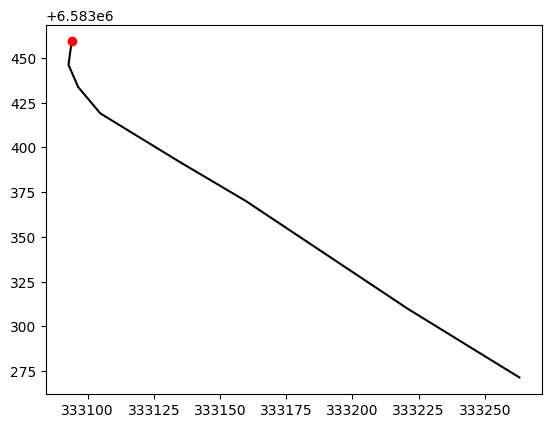

In [7]:
from matplotlib import pyplot as plt

point = from_wkt('POINT (333093.94 6583459.09)')
line = from_wkt('LINESTRING (333093.94 6583459.09, 333092.75 6583446.01, 333096.38 6583433.67, 333104.76 6583418.93, 333134.17 6583392.33, 333159.7 6583370.03, 333220.98 6583309.73, 333232.44 6583299.31, 333263.08 6583271.44)')


# Создаем новый график
fig, ax = plt.subplots()

# Добавляем линию на график
x, y = line.xy
ax.plot(x, y, color='black')

# Добавляем точку на график
x, y = point.xy
ax.plot(x, y, 'o', color='red')

# Показываем график
plt.show()

In [29]:
from src.dongraphio.utils import get_osmnx_graph
from shapely import LineString
import osmnx as ox
drive_graph: nx.MultiDiGraph = get_osmnx_graph(
    176095, 32636, "drive_service", truncate_by_edge=False
)
nx.write_graphml(drive_graph, "graph_LO.graphml")
# for i in drive_graph.edges(data=True):
#     i[2]['geometry'] = from_wkt(i[2]['geometry'])
# 
# gdf_graph_edges = ox.graph_to_gdfs(drive_graph, nodes=False)
# gdf_graph_edges.to_file('graph_LO.geojson')

2024-03-29 18:04:01.129 | DEBUG    | src.dongraphio.utils.graphs:get_osmnx_graph:58 - Extracting and preparing drive_service graph from OSM ...
C:\Users\Donny\AppData\Local\pypoetry\Cache\virtualenvs\graph-lib-8TUFT-q0-py3.11\Lib\site-packages\osmnx\_overpass.py:211: UserWarning: This area is 51 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


KeyboardInterrupt: 